In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

matplotlib.rc("axes", **{"spines.top": False, "spines.right": False})
matplotlib.rc("legend", frameon=False)

In [2]:
def name(s: pd.Series) -> str:
    method = re.sub(r"(^\.+)|(\.+$)", "", re.sub(r"\b(approx_topk|exact_methods|topk|__main__)\b", "", s.method))
    args = ", ".join(f"{k}={v}" for k, v in s.args.items())
    return f"{method}({args})".replace("()", "")

df = (pd.read_json("../results/measure_speed.jsonl", lines=True)
    .pipe(lambda d: d.assign(
        input_mode=d.n_inner_inputs.apply(lambda x: "small" if x == 1 else "large"),
        compile=d.compile.fillna("eager"),
        method=d.apply(name, axis=1),
        k_ratio=d.topk_size//d.k,
        duration=d.duration.apply(np.mean) / d.n_inner,
        duration_stderr=d.duration.apply(lambda d: np.std(d)/np.sqrt(len(d))) / d.n_inner,
    ))
    .pipe(lambda d: d.assign(
        bandwidth=d.dtype.apply(dict(float32=4, float16=2).__getitem__) * d.topk_size * d.batch_size / d.duration,
    ))
)
df.head()

,args,compile,cuda_graphs,batch_size,topk_size,k,n_warmup,n_outer,n_inner,n_inner_inputs,method,dtype,duration,device,input_mode,k_ratio,duration_stderr,bandwidth
0,{},eager,True,32,4096,1024,16,16,128,NaN,fake_topk_sum,float16,0.000015,NVIDIA A10G,large,4,1.391952e-09,1.754293e+10
1,{},eager,True,32,4096,512,16,16,128,NaN,fake_topk_sum,float16,0.000015,NVIDIA A10G,large,8,2.204416e-09,1.753882e+10
2,{},eager,True,32,4096,256,16,16,128,NaN,fake_topk_sum,float16,0.000015,NVIDIA A10G,large,16,1.763355e-09,1.754352e+10
3,{},eager,True,32,4096,128,16,16,128,NaN,fake_topk_sum,float16,0.000015,NVIDIA A10G,large,32,1.727548e-09,1.753765e+10
4,{},eager,True,32,16384,4096,16,16,128,NaN,fake_topk_sum,float16,0.000007,NVIDIA A10G,large,4,2.121323e-09,1.534801e+11


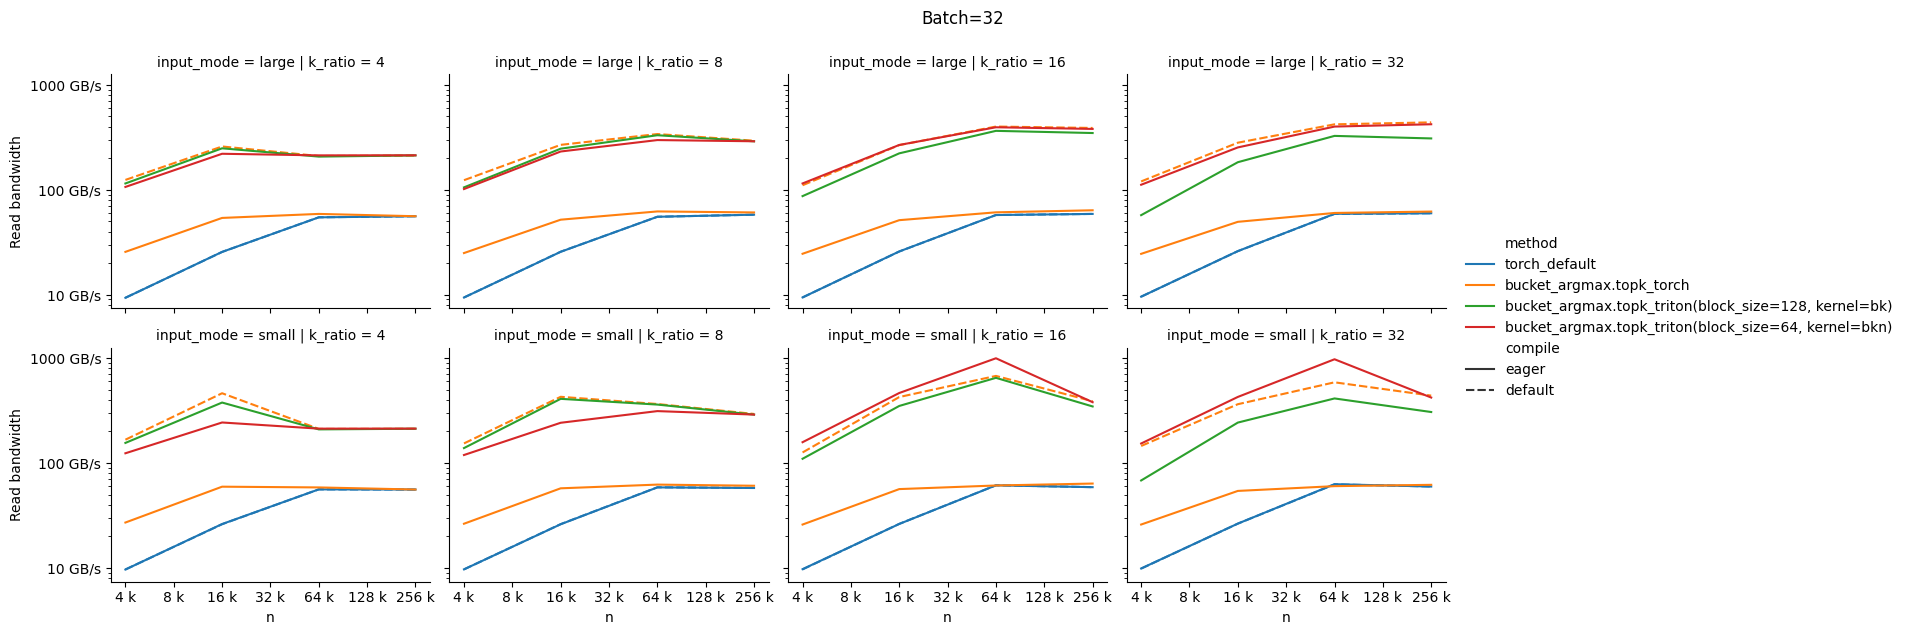

In [3]:
batch_size, = df.batch_size.unique()
g = sns.relplot(data=df[df.method!="fake_topk_sum"], y="bandwidth", x="topk_size", hue="method", col="k_ratio", row="input_mode", style="compile",
                kind="line", height=3, aspect=1.2)
for ax in g.axes.flatten():
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(lambda x, _: f"{x/1e9:.0f} GB/s")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x//1024:.0f} k")
    ax.set_xlabel("n")
    ax.set_ylabel("Read bandwidth")
plt.suptitle(f"Batch={batch_size}", y=1.05);